# Gaussian Processes as White noise-driven SDEs

See various works by Hartikainen, Solin and S√§rkk√§.

## Import libraries

UndefVarError: UndefVarError: GadFly not defined

In [1]:
using LinearAlgebra
using SparseArrays
using Distributions
using SpecialFunctions
using Plots

 ## Utility Functions
 
 - `lyapchol` : Solving the continuous Lyapunov equation ensuring positive-definiteness
 - `assertposdef!` : Asserts a square matrix is positive-definite, and tries to enforce positive-definiteness if possible
 - `assertparams!` : Asserts parameters exist in dictionary, and sets to default value if not

In [2]:
function lyapchol(A, B, uplo::Symbol=:L)
    """ Solve the Riccati equation AX + XA' + B = 0
            using Cholesky decomposition to ensure positive-definiteness
        Returns triangular matrix representing the cholesky decomposition of X
            By default, this is the lower triangular form, unless uplo=:U
    """
    if size(A,1) == 1
        if size(B,1) == 1
            typeof(A) <: AbstractArray ? A = A[1] : nothing;
            typeof(B) <: AbstractArray ? B = B[1] : nothing;
            X = ‚àö(-(B*B) / 2A);
        else
            error("A and B should be the same size");
        end
    else
        X = cholesky(Hermitian(lyap(A, B*B')))
        X = uplo == :U ? X.U : X.L
    end
    return X
end

@inline function assertposdef!(A; report::Bool=false)
    """ Checks positive definiteness of matrix """
    size(A,1) ‚â† size(A,2) ? error("Matrix must be square !") : nothing;
    if isposdef(A)
        report ? println("Confirmed that matrix is positive definite.") : nothing;
    elseif isposdef(A + eps()*I)
        report ? println("Matrix was not positive definite, incrementing with Œµ‚ãÖùêà") : nothing;
        A += eps()*I;
    else
        report ? println("Matrix was not positive definite, attempting to make positive definite.") : nothing;
        U,S,V = svd(A + eps()*I)
        L = U * Diagonal(sqrt.(S));
        A .= L*L';
        isposdef(A) ? (report ? println("Made matrix positive definite.") : nothing) : error("Could not make matrix positive definite.");
    end
end

function assertparams!(
        Œ∏::Dict,
        keys::Union{Tuple,AbstractArray},
        default::Union{Tuple,AbstractArray};
        alt_names::Union{Missing,Union{Tuple,AbstractArray}}=missing
    )
    """ Checks parameter keys exist and if they don't, assigns them with default values.
            Can provide an optional list of alternative names for keys.
    """
    
    # Check number of keys and number of default parameters is the same
    if length(keys) ‚â† length(default)
        error("List of parameter names and list of default values must have the same length!")
    # If alt_names list is provided, make sure if is the same length as keys
    elseif ~ismissing(alt_names) && length(keys) ‚â† length(alt_names)
        println("Warning: if providing list of alternative parameter names, it must be same length as keys.")
        println("         Ignoring list of alternative names.");
        # If not, ignore alt_names
        alt_names = missing;
    end
    
    # Check through list of keys in dictionary and assign default value if missing
    for (i,k,d) ‚àà zip(1:length(keys), keys, default)
        # If key not present
        if k ‚àâ Base.keys(Œ∏)
            # Check alternative naming, if provided
            if ~ismissing(alt_names)
                if typeof(alt_names[i]) <: Union{AbstractArray, Tuple}
                    for alt_k ‚àà alt_names[i]
                        # Take only first correct alternative name (in case of multiple matching)
                        if alt_k ‚àà Base.keys(Œ∏)
                            Œ∏[k] = Œ∏[alt_k];
                            break
                        end
                    end
                    k ‚àâ Base.keys(Œ∏) ? Œ∏[k] = d : nothing;
                else
                    alt_names[i] ‚àà Base.keys(Œ∏) ? Œ∏[k] = Œ∏[alt_names[i]] : Œ∏[k] = d;
                end
            else
                # Assign default value if no alternative name matches
                Œ∏[k] = d;
            end
        end
    end
end

assertparams! (generic function with 1 method)

### Calculate steady-state covariance of system

We obtain the steady-state covariance of 
$$\mathrm{d}\mathbf{x}(t) = \mathbf{F}\mathbf{x}(t)\mathrm{d}t + \mathbf{L}\mathrm{d}\mathbf{\beta}(t)$$
by solving the Riccati equation:
$$
    \frac{\mathrm{d}}{\mathrm{d}t}\mathbf{P} = \mathbf{F}\mathbf{P}_\infty + \mathbf{P}_\infty\mathbf{F}^\mathrm{T} + \mathbf{L}q\mathbf{L}^\mathrm{T} = 0,
$$
where $\mathbf{P}$ is the covariance of the system and $\mathbf{P}_\infty$ is the solution.

In [3]:
function cov_seq_steadystate(ùêÖ, ùêã, ùëû; chol::Bool=false, uplo::Symbol=:L)
    """ Calculate steady state covariance by solving Riccati equation """
    
    if typeof(ùëû) <: AbstractArray 
        return cov_seq_periodic(ùêÖ, ùêã, ùëû, chol=chol, uplo=uplo)
    elseif ~(typeof(ùêÖ) <: AbstractArray) && isnan(ùêÖ)
        ùêø = ‚àöùëû
        return chol ? ùêø : ùêø*ùêø
    else
        ùêø = lyapchol(ùêÖ, ùêã*‚àöùëû, uplo);
        return chol ? ùêø : uplo == :U ? ùêø'*ùêø : ùêø*ùêø'
    end
end

function cov_seq_periodic(ùêÖ, ùêã, ùëû; chol::Bool=false, uplo::Symbol=:L)
    P = chol ? blockdiag(map(a -> sqrt.(a), ùëû)...) : blockdiag(ùëû...)
    return issparse(ùêÖ) ? P : Matrix(P)
end

cov_seq_periodic (generic function with 1 method)

### Sample a kernel sequentially

In [4]:
function sample_seq_kernel(
        t::AbstractArray;
        k::Function=kern_seq_matern,
        Œ∏::Union{Dict,Missing}=missing
    )
    """ Sample a given kernel definition sequentially at inputs t"""
    length(t) == 1 ? (return randn(1,1)) : nothing
    
    # Sort t
    t = collect(t);
    sort!(t)
    
    # Get evolutionary matrix components dùê± = ùêÖùê±(t)dt + ùêãdùõÉ ; f(t) = ùêáùê±(t)
    F, L, q, H = k(Œ∏=Œ∏);
    
    # Calculate the steady-state covariance of the system ùêè‚àû
    P‚ÇÄ = cov_seq_steadystate(F, L, q);
    
    # If t is uniformly spaced, only need to discretise once
    uniform_spacing = all((t[2]-t[1]) .‚âà (t[2:end] .- t[1:end-1]));
    if uniform_spacing
        # Discretize once: ùêÄ = exp(Œî‚ÇúùêÖ)
        if typeof(F) <: AbstractArray
            A = exp(F * (t[2]-t[1]));
            # Create positive definite evolutionary covariance
            Q = Hermitian(P‚ÇÄ - A*P‚ÇÄ*A') |> Matrix; assertposdef!(Q);
        else
            A = isnan(F) ? 0. : exp(F * (t[2]-t[1]))
            Q = P‚ÇÄ - A*P‚ÇÄ*A'
        end
    end

    # Create variables
    f = zeros(length(t)); # output sample
    Œº = typeof(P‚ÇÄ) <: AbstractArray ? rand(MvNormal(P‚ÇÄ)) : P‚ÇÄ > 0. ? rand(Normal(0., P‚ÇÄ)) : 0.
    #Œº = zeros(size(F,1)); # latent state of SDE: Œº ‚âú ùê±(t‚Çñ)
    
    for k = 1:length(t)
        # We only need to do this for non-uniform spacing
        if ~uniform_spacing
            # Discretize: ùêÄ = exp(Œî‚ÇúùêÖ)
            Œî = (k == 1 ? t[2]-t[1] : (t[k]-t[k-1]));
            if typeof(F) <: AbstractArray
                # Create positive definite evolutionary covariance
                A = exp(F * Œî);
                Q = Hermitian(P‚ÇÄ - A*P‚ÇÄ*A') |> Matrix; assertposdef!(Q);
            else
                A = isnan(F) ? 0. : exp(F * Œî)
                Q = P‚ÇÄ - A*P‚ÇÄ*A'
            end
        end
        # Propagate evolutionary SDE
        Œº = A*Œº .+ (typeof(Q) <: AbstractArray ? rand(MvNormal(Q)) : Q > 0. ? rand(Normal(0., Q)) : 0.);
        # Extract sample at t‚Çñ
        f[k] = (H*Œº)[1];
    end
    
    return f
end

sample_seq_kernel (generic function with 1 method)

## Combining Kernels



In [5]:
function kern_seq_sum(
        k‚ÇÅ::Function, k‚ÇÇ::Function;
        Œ∏‚ÇÅ::Union{Dict, Missing} = missing,
        Œ∏‚ÇÇ::Union{Dict, Missing} = missing
    )
    """ Sum of two kernels """
    ùêÖ‚ÇÅ, ùêã‚ÇÅ, ùëû‚ÇÅ, ùêá‚ÇÅ = k‚ÇÅ(Œ∏=Œ∏‚ÇÅ)
    ùêÖ‚ÇÇ, ùêã‚ÇÇ, ùëû‚ÇÅ, ùêá‚ÇÇ = k‚ÇÇ(Œ∏=Œ∏‚ÇÇ)
    
    # Utility function
    blkdiag(A,B) = [A zeros(size(A,1),size(B,2)) ; zeros(size(B,1),size(A,2)) B]
    
    ùêÖ = blkdiag(ùêÖ‚ÇÅ,ùêÖ‚ÇÇ)
    ùêã = blkdiag(ùêã‚ÇÅ,ùêã‚ÇÇ)
    ùëû = [ùëû‚ÇÅ,ùëû‚ÇÇ]
    ùêá = [ùêá ùêá]
    
    return ùêÖ, ùêã, ùëû, ùêá
end

function kern_seq_prod(
        k‚ÇÅ::Function, k‚ÇÇ::Function;
        Œ∏‚ÇÅ::Union{Dict, Missing} = missing,
        Œ∏‚ÇÇ::Union{Dict, Missing} = missing
    )
    """ Product of two kernels """
    ùêÖ‚ÇÅ, ùêã‚ÇÅ, ùëû‚ÇÅ, ùêá‚ÇÅ = k‚ÇÅ(Œ∏=Œ∏‚ÇÅ)
    ùêÖ‚ÇÇ, ùêã‚ÇÇ, ùëû‚ÇÇ, ùêá‚ÇÇ = k‚ÇÇ(Œ∏=Œ∏‚ÇÇ)
    
    # Utility function
    ‚äó(A,B) = kron(A,B)
    
    ùêÖ = (ùêÖ‚ÇÅ ‚äó Matrix(I,size(ùêÖ‚ÇÅ,1),size(ùêÖ‚ÇÅ,2))) + (Matrix(I,size(ùêÖ‚ÇÇ,1),size(ùêÖ‚ÇÇ,2)) ‚äó ùêÖ‚ÇÇ)
    ùêã = ùêã‚ÇÅ ‚äó ùêã‚ÇÇ
    ùëû = ùëû‚ÇÅ*ùëû‚ÇÇ
    ùêá = ùêá‚ÇÅ ‚äó ùêá‚ÇÇ
    
    return ùêÖ, ùêã, ùëû, ùêá
end

function kern_seq_periodic_matern(;
        ùêΩ::Int = 5; # Approximation order
        ŒΩ::Union{Missing, Number} = missing, # Matern smoothness
        œâ::Union{Missing, Number} = missing, # Frequency
        l::Union{Missing, Number,AbstractArray} = missing, # Length scale
        v::Union{Missing, Number,AbstractArray} = missing, # Variance
        Œ∏::Union{Missing, Dict} = missing  # Dictionary of parameters
    )
    """ """
    
    Œ∏_periodic = deepcopy(Œ∏)
    Œ∏_matern   = deepcopy(Œ∏)
    
    ismissing(l) ? nothing : (Œ∏_periodic[:l], Œ∏_matern[:l]) .= l;
    ismissing(v) ? nothing : (Œ∏_periodic[:v], Œ∏_matern[:v]) .= v;
    if ismissing(l)
        for k ‚àà (:l,:ls,:lengthscale,:lengthscales)
            if k ‚àà keys(Œ∏)
                (Œ∏_periodic[:l], Œ∏_matern[:l]) = length(Œ∏[:k]) > 1 ? Œ∏[:k] : (Œ∏[:k], Œ∏[:k])
               break
            end
            
        end
    else
        (Œ∏_periodic[:l], Œ∏_matern[:l]) = length(l) > 1 ? l : (l,l);
    end
    if ismissing(v)
        for k ‚àà (:variance, :variances, :œÉ¬≤, :scales)
            if k ‚àà keys(Œ∏)
                (Œ∏_periodic[:v], Œ∏_matern[:v]) = length(Œ∏[:k]) > 1 ? Œ∏[:k] : (Œ∏[:k], Œ∏[:k])
                break
            end
        end
    else
        (Œ∏_periodic[:v], Œ∏_matern[:v]) = length(v) > 1 ? v : (v,v);
    end
    
    ùêÖ·µ©, ùêã·µ©, ùëû·µ©, ùêá·µ© = kern_seq_periodic(ùêΩ=ùêΩ, œâ=œâ, Œ∏=Œ∏_periodic)
    ùêÖ‚Çò, ùêã‚Çò, ùëû‚Çò, ùêá‚Çò = kern_seq_matern(ŒΩ=ŒΩ, Œ∏=Œ∏_matern)
    
    # Utility function
    ‚äó(A,B) = kron(A,B)
    
    ùêÖ = (ùêÖ‚Çò ‚äó Matrix(I,size(ùêÖ·µ©,1),size(ùêÖ·µ©,2))) + (Matrix(I,size(ùêÖ‚Çò,1),size(ùêÖ‚Çò,2)) ‚äó ùêÖ·µ©)
    ùêã = ùêã‚Çò ‚äó ùêã·µ©
    ùëû = ùëû‚ÇÅ*ùëû‚ÇÇ
    ùêá = ùêá‚Çò ‚äó ùêá·µ©
    
    return ùêÖ, ùêã, ùëû, ùêá
    
end

ErrorException: syntax: more than one semicolon in argument list

## Kernels definitions

### Mat√©rn
Mat√©rn half-integer covariance functions and exponential kernel.

In [6]:
Œ∏=Dict()
(Œ∏[:a],Œ∏[:b]) = (1.,2.)
Œ∏

Dict{Any,Any} with 2 entries:
  :a => 1.0
  :b => 2.0

In [7]:
function kern_seq_matern(;
        ŒΩ::Union{Missing, Number} = missing, # Smoothness
        Œª::Union{Missing, Number} = missing, # State space parameter
        l::Union{Missing, Number} = missing, # Length scale
        v::Union{Missing, Number} = missing, # Variance (not to be confused with ŒΩ (nu))
        Œ∏::Union{Dict, Missing} = missing,
        _balance::Bool = true)
    """ Sequential version of Mat√©rn half-integer kernel """
    # Fills Œ∏ with default parameters
    ismissing(Œ∏) ? Œ∏ = Dict{Symbol, Float64}() : nothing;
    assertparams!(Œ∏,
        (:ŒΩ, :l, :v), (1.5, 1.0, 1.0),
        alt_names=((:smoothness),(:ls,:lengthscale),(:variance,:œÉ¬≤))
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in Œ∏
    # : If neither exist, uses default values
    ŒΩ = ismissing(ŒΩ) ? Œ∏[:ŒΩ] : Float64(ŒΩ);
    l = ismissing(l) ? Œ∏[:l] : Float64(l);
    v = ismissing(v) ? Œ∏[:v] : Float64(v);
    
    # CHECK UPPER LIMIT ON ŒΩ
    ŒΩ > 11. ? error("Unable to calculate exact kernel for ŒΩ > 10.5.") : nothing
    # TODO: implement approximation method (?)
    
    # Check ŒΩ is half-integer
    if floor(Int,ŒΩ-0.5) ‚â† ŒΩ-0.5
        print("ŒΩ should be half-integer: rounding to nearest half-integer ‚åäŒΩ‚åã+0.5");
        ŒΩ = floor(ŒΩ) + 0.5;
        print(" = "); println(ŒΩ)
    end
    
    # State dimensionality
    ùê∑ = Int(ŒΩ + 0.5);
    # Calculate Œª if necessary (alt. set lengthscale based on Œª)
    ismissing(Œª) ? Œª = ‚àö(2ŒΩ)/l : l = ‚àö(2ŒΩ)/Œª;

    if ùê∑ ‚â° 1 # Exponential kernel: ŒΩ = ¬Ω
        ùêÖ = -Œª; ùêã = 1.; ùëû = 2v/l; ùêá = 1.;
    else
        # Evolutionary state process
        ùêÖ = Bidiagonal(zeros(ùê∑), ones(ùê∑-1), :U) |> Matrix;
        ùêÖ[ùê∑,:] = -map(ùëñ -> Float64(binomial(ùê∑, ùëñ-1)), 1:ùê∑) .* Œª.^(ùê∑:-1:1);
        # White noise evolution
        ùêã = zeros(ùê∑, 1); ùêã[ùê∑] = 1.;
        # Diffusion coefficient
        ùëû = v*(factorial(ùê∑-1)^2 / factorial(2ùê∑-2))*(2Œª)^(2ùê∑-1);
        # Measurement model
        ùêá = zeros(1, ùê∑); ùêá[1] = 1.;
        
        if _balance # Rebalances system to avoid overflow
            (_,_,scl) =  LAPACK.gebal!('B',ùêÖ);
            ùêã  = Diagonal(scl) \ ùêã;
            ùêá *= Diagonal(scl);
        end
        
    end
    
    return ùêÖ, ùêã, ùëû, ùêá
end

function kern_seq_exponential(;
    l::Union{Missing, Number} = missing, # Length scale
    v::Union{Missing, Number} = missing, # Variance (not to be confused with ŒΩ (nu))
    Œ∏::Union{Dict, Missing}   = missing
    )
    """ Sequential version of exponential kernel """
    return kern_seq_matern(ŒΩ=0.5, l=l, v=v, Œ∏=Œ∏, _balance=false); 
end

kern_seq_exponential (generic function with 1 method)

### Periodic

In [85]:
function kern_seq_periodic(
    ùêΩ::Int = 5; # Approximation order
    œâ::Union{Missing, Number} = missing, # Frequency
    l::Union{Missing, Number} = missing, # Length scale
    v::Union{Missing, Number} = missing, # Variance
    Œ∏::Union{Missing, Dict}   = missing  # Dictionary of parameters
    )
    """ Sequential approximation of canonical periodic kernel """
    # Fills Œ∏ with default parameters
    ismissing(Œ∏) ? Œ∏ = Dict{Symbol, Float64}() : nothing;
    assertparams!(Œ∏,
        (:œâ, :l, :v, :ùêΩ, :sparse), (1.0, 1.0, 1.0, ùêΩ, 0.0),
        alt_names=((:frequency,:period),(:ls,:lengthscale),(:variance,:œÉ¬≤),(:limit,:order),())
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in Œ∏
    # : If neither exist, uses default values
    œâ = ismissing(œâ) ? Œ∏[:œâ] : Float64(œâ);
    l = ismissing(l) ? Œ∏[:l] : Float64(l);
    v = ismissing(v) ? Œ∏[:v] : Float64(v);
    # Overwrite default ùêΩ with value from Œ∏ if present
    ùêΩ == 5 ? ùêΩ = Int(Œ∏[:ùêΩ]) : nothing;
    
    F = Array{SparseMatrixCSC}(undef,ùêΩ+1)
    L = Array{SparseMatrixCSC}(undef,ùêΩ+1)
    H = Array{SparseMatrixCSC}(undef,ùêΩ+1)
    ùëû = Array{SparseMatrixCSC}(undef,ùêΩ+1)

    l‚Åª¬≤ = 1.0/(l^2); expl‚Åª¬≤ = exp(l‚Åª¬≤)
    for j ‚àà 0:ùêΩ
        F[j+1] = sparse([1,2],[2,1],[-œâ*j,œâ*j],2,2);
        L[j+1] = sparse(I,2,2);
        H[j+1] = sparse([1],[1],[1],1,2);
        
        ùëû‚±º = besseli(j, l‚Åª¬≤) / expl‚Åª¬≤
        ùëû[j+1] = (j > 0 ? 2ùëû‚±º : ùëû‚±º).*sparse(I,2,2);
    end
    
    ùêÖ = blockdiag(F...)
    ùêã = blockdiag(L...)
    ùêá = cat(H..., dims=2)
    
    if Œ∏[:sparse] == 1
        return ùêÖ, ùêã, ùëû, ùêá
    else
        return Matrix(ùêÖ), Matrix(ùêã), ùëû, Matrix(ùêá)
    end
end

kern_seq_periodic (generic function with 2 methods)

### White

In [199]:
function kern_seq_white(;
    v::Union{Missing, Number} = missing, # Variance
    Œ∏::Union{Missing, Dict}   = missing  # Dictionary of parameters
    )
    """ White noise kernel """
    ismissing(Œ∏) ? Œ∏ = Dict{Symbol, Float64}() : nothing;
    assertparams!(Œ∏,
        [:v], [1.0],
        alt_names=[(:variance,:œÉ¬≤)]
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in Œ∏
    # : If neither exist, uses default values
    v = ismissing(v) ? Œ∏[:v] : Float64(v);
    
    # White noise parameters
    ùêÖ = NaN; ùêã = 1; ùëû = v; ùêá = 1;
    
    return ùêÖ, ùêã, ùëû, ùêá
end

function kern_seq_brownian(; # THIS IS WRONG (?)
    v::Union{Missing, Number} = missing, # Variance
    Œ∏::Union{Missing, Dict}   = missing  # Dictionary of parameters
    )
    """ White noise kernel """
    ismissing(Œ∏) ? Œ∏ = Dict{Symbol, Float64}() : nothing;
    assertparams!(Œ∏,
        [:v], [1.0],
        alt_names=[(:variance,:œÉ¬≤)]
    )
    # Set values of parameters,
    # : Explicit statement overrides definition in Œ∏
    # : If neither exist, uses default values
    v = ismissing(v) ? Œ∏[:v] : Float64(v);
    
    # White noise parameters
    ùêÖ = -v; ùêã = 1.; ùëû = 1.; ùêá = 1.;
    
    return ùêÖ, ùêã, ùëû, ùêá
end



kern_seq_brownian (generic function with 1 method)

## Examples

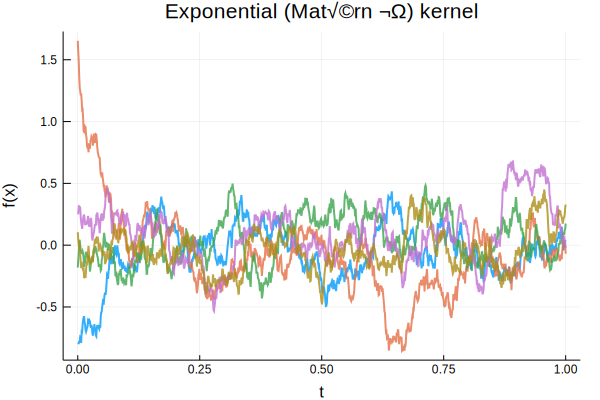

In [102]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Exponential (Mat√©rn ¬Ω) kernel")
for _ ‚àà 1:n 
    f = sample_seq_kernel(t, k=kern_seq_exponential, Œ∏=Dict(:lengthscale=>0.05));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

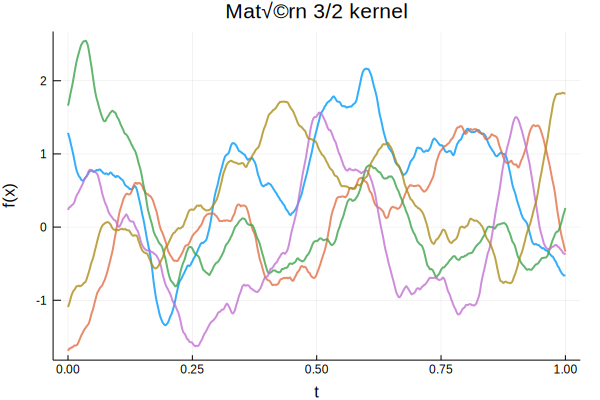

In [103]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Mat√©rn 3/2 kernel")
for _ ‚àà 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, Œ∏=Dict(:ŒΩ=>1.5, :lengthscale=>0.1));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

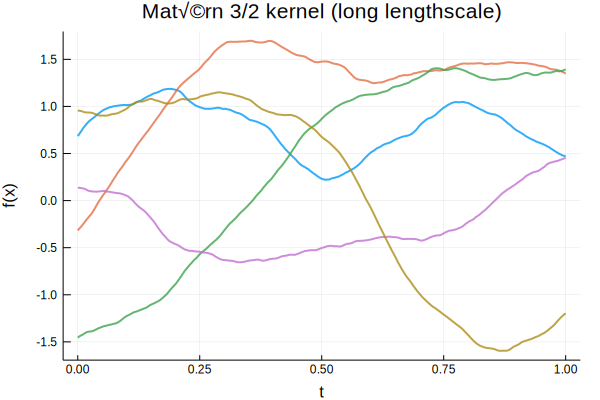

In [104]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Mat√©rn 3/2 kernel (long lengthscale)")
for _ ‚àà 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, Œ∏=Dict(:ŒΩ=>1.5, :lengthscale=>0.5));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

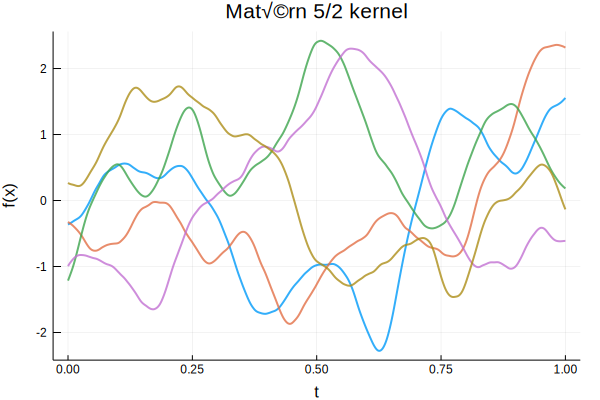

In [105]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Mat√©rn 5/2 kernel")
for _ ‚àà 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, Œ∏=Dict(:ŒΩ=>2.5, :lengthscale=>0.1));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

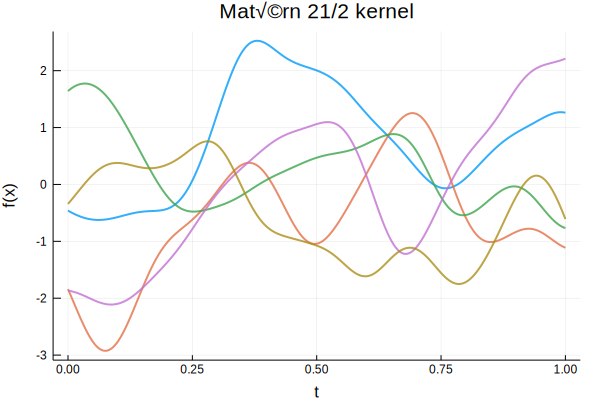

In [106]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Mat√©rn 21/2 kernel")
for _ ‚àà 1:n 
    f = sample_seq_kernel(t, k=kern_seq_matern, Œ∏=Dict(:ŒΩ=>10.5, :lengthscale=>0.1));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

### Periodic

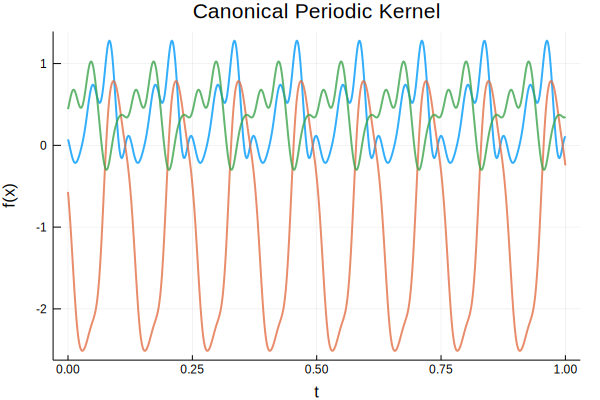

In [107]:
t = LinRange(0.,1.,1000)

n = 3;
p = plot(legend=:none, title="Canonical Periodic Kernel")
for _ ‚àà 1:n 
    f = sample_seq_kernel(t, k=kern_seq_periodic, Œ∏=Dict(:period=>50.,:lengthscale=>1.0, :order=>8));
    plot!(t,f, lw=2, alpha=0.8)
end
xlabel!("t"); ylabel!("f(x)")

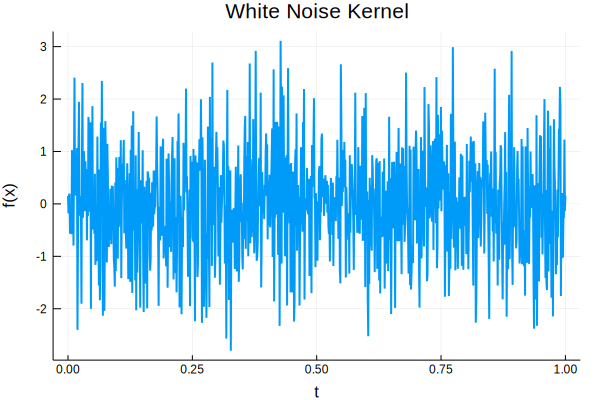

In [108]:
t = LinRange(0.,1.,1000)

n = 1;
p = plot(legend=:none, title="White Noise Kernel")
for _ ‚àà 1:n 
    f = sample_seq_kernel(t, k=kern_seq_white, Œ∏=Dict(:variance=>1.));
    plot!(t,f, lw=2, alpha=1.0)
end
xlabel!("t"); ylabel!("f(x)")

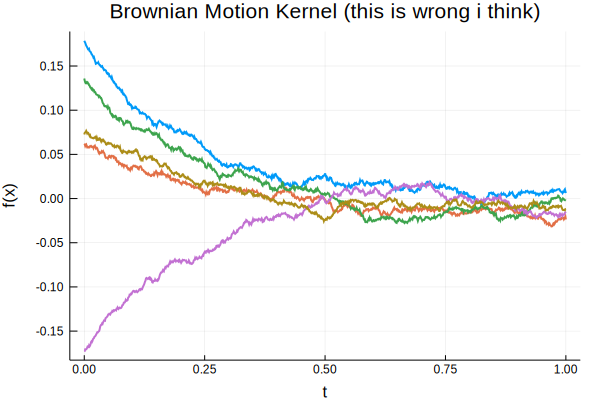

In [200]:
t = LinRange(0.,1.,1000)

n = 5;
p = plot(legend=:none, title="Brownian Motion Kernel (this is wrong i think)")
for _ ‚àà 1:n
    f = sample_seq_kernel(t, k=kern_seq_brownian, Œ∏=Dict(:variance=>5.));
    plot!(t,f, lw=2, alpha=1.0)
end
xlabel!("t"); ylabel!("f(x)")